In [43]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Read Data

In [45]:
df = pd.read_csv("./MaunaLoaDailyTemps.csv", index_col="DATE", parse_dates=True)
df = df.dropna()
print("Shape of data", df.shape)
df.head()

Shape of data (1821, 5)


,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2014-01-01,33.0,46.0,40.0,657,1756
2014-01-02,35.0,50.0,43.0,657,1756
2014-01-03,36.0,45.0,41.0,657,1757
2014-01-04,32.0,41.0,37.0,658,1757
2014-01-05,24.0,38.0,31.0,658,1758


# Plot Your Data

<Axes: xlabel='DATE'>

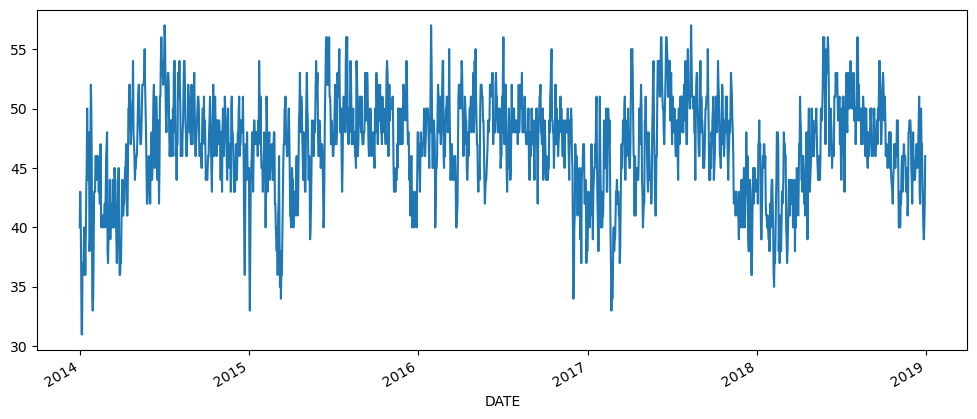

In [46]:
df["AvgTemp"].plot(figsize=(12, 5))

# Check For Stationarity

In [47]:
from statsmodels.tsa.stattools import adfuller


def adf_test(dataset):
    dftest = adfuller(dataset, autolag="AIC")
    print("1. ADF : ", dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print(
        "4. Num Of Observations Used For ADF Regression and Critical Values Calculation :",
        dftest[3],
    )
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t", key, ": ", val)

In [48]:
adf_test(df["AvgTemp"])

1. ADF :  -6.554680125068781
2. P-Value :  8.67593748019951e-09
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1808
5. Critical Values :
	 1% :  -3.433972018026501
	 5% :  -2.8631399192826676
	 10% :  -2.5676217442756872


# Model Identification (ACF plot)


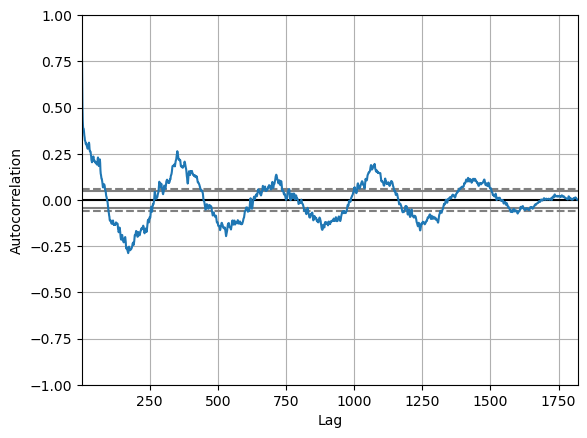

In [49]:
pd.plotting.autocorrelation_plot(df["AvgTemp"])
plt.show()

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

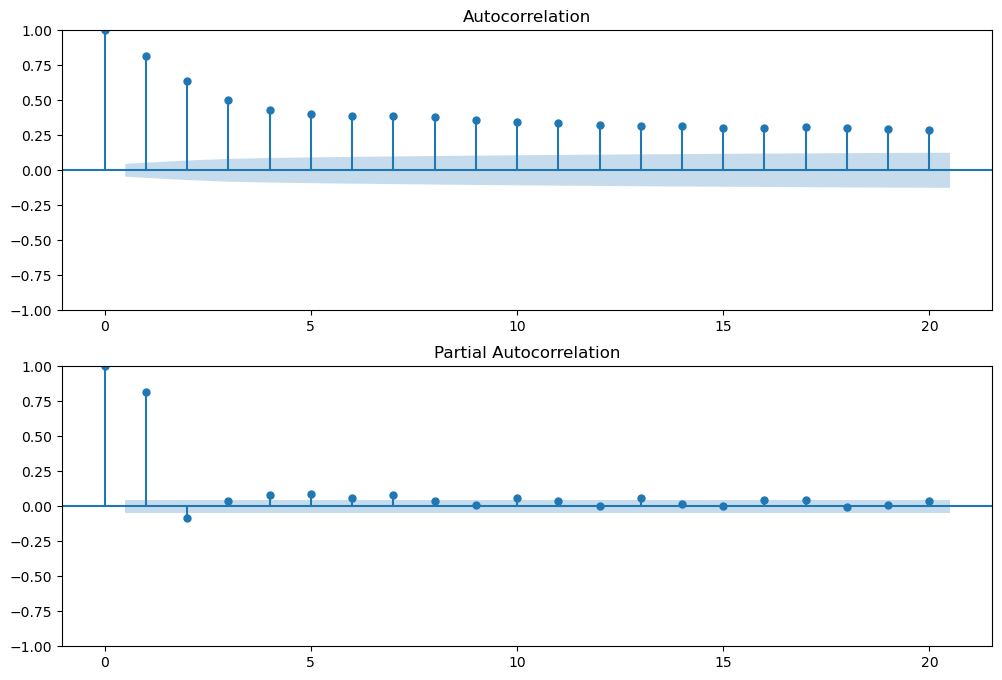

In [51]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["AvgTemp"].dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["AvgTemp"].dropna(), lags=20, ax=ax2)

# Figure Out Order for ARIMA Model

In [52]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings

warnings.filterwarnings("ignore")

In [53]:
stepwise_fit = auto_arima(df["AvgTemp"], suppress_warnings=True)

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1821
Model:               SARIMAX(1, 0, 5)   Log Likelihood               -4139.901
Date:                Wed, 17 Jan 2024   AIC                           8295.802
Time:                        20:19:03   BIC                           8339.859
Sample:                             0   HQIC                          8312.055
                               - 1821                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3611      0.397      3.429      0.001       0.583       2.139
ar.L1          0.9707      0.009    113.485      0.000       0.954       0.987
ma.L1         -0.1220      0.024     -5.088      0.000      -0.169      -0.075
ma.L2         -0.2156      0.024     -8.841      0.000      -0.263      -0.168
ma.L3         -0.2029      0.024     -8.430      0.000      -0.250      -0.156
ma.L4         -0.1344      0.023     -5.884      0.000      -0.179      -0.090
ma.L5         -0.0458      0.024     -1.874      0.061      -0.094       0.002
sigma2         5.5003      0.172     31.930      0.000       5.163       5.838
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                21.32
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
from statsmodels.tsa.arima_model import ARIMA

 # Split Data into Training and Testing

In [55]:
print(df.shape)
train = df.iloc[:-30]
test = df.iloc[-30:]
print(train.shape, test.shape)
print(test.iloc[0], test.iloc[-1])

(1821, 5)
(1791, 5) (30, 5)
MinTemp      36.0
MaxTemp      52.0
AvgTemp      44.0
Sunrise     640.0
Sunset     1743.0
Name: 2018-12-01 00:00:00, dtype: float64 MinTemp      39.0
MaxTemp      52.0
AvgTemp      46.0
Sunrise     656.0
Sunset     1754.0
Name: 2018-12-30 00:00:00, dtype: float64


# Train the Model

In [56]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train["AvgTemp"], order=(1, 0, 5))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                AvgTemp   No. Observations:                 1791
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -4070.198
Date:                Wed, 17 Jan 2024   AIC                           8156.395
Time:                        20:19:04   BIC                           8200.320
Sample:                             0   HQIC                          8172.614
                               - 1791                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.5856      0.758     61.454      0.000      45.100      48.071
ar.L1          0.9856      0.005    188.230      0.000       0.975       0.996
ma.L1         -0.1412      0.023     -6.124      0.000      -0.186      -0.096
ma.L2         -0.2268      0.024     -9.635      0.000      -0.273      -0.181
ma.L3         -0.2168      0.023     -9.251      0.000      -0.263      -0.171
ma.L4         -0.1479      0.023     -6.491      0.000      -0.193      -0.103
ma.L5         -0.0595      0.024     -2.438      0.015      -0.107      -0.012
sigma2         5.5093      0.174     31.624      0.000       5.168       5.851
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.88
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Make Predictions on Test Set

<Axes: xlabel='DATE'>

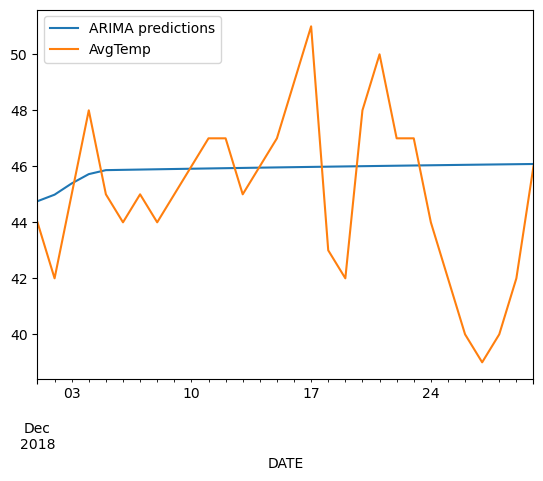

In [57]:
start = len(train)
end = len(train) + len(test) - 1
# if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')
pred = model.predict(start=start, end=end, typ="levels").rename("ARIMA predictions")
pred.index=index_future_dates
pred.plot(legend=True)
test["AvgTemp"].plot(legend=True)

<Axes: xlabel='DATE'>

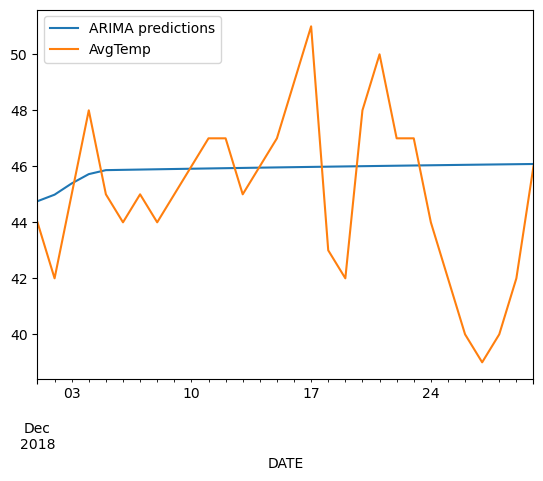

In [58]:
pred.plot(legend="ARIMA Predictions")
test["AvgTemp"].plot(legend=True)

In [59]:
test["AvgTemp"].mean()

45.0

In [60]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(pred, test["AvgTemp"]))
print(rmse)

3.000463922857349


In [61]:
model2 = ARIMA(df["AvgTemp"], order=(1, 0, 5))
model2 = model2.fit()
df.tail()

,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
DATE,,,,,
2018-12-26,35.0,45.0,40.0,654,1752
2018-12-27,33.0,44.0,39.0,655,1752
2018-12-28,33.0,47.0,40.0,655,1753
2018-12-29,36.0,47.0,42.0,655,1753
2018-12-30,39.0,52.0,46.0,656,1754


# For Future Dates

In [62]:
index_future_dates = pd.date_range(start="2018-12-30", end="2019-01-29")
# print(index_future_dates)
pred = model2.predict(start=len(df), end=len(df) + 30, typ="levels").rename(
    "ARIMA Predictions"
)
# print(comp_pred)
pred.index = index_future_dates
print(pred)

2018-12-30    46.418166
2018-12-31    46.113912
2019-01-01    45.617874
2019-01-02    45.249566
2019-01-03    45.116916
2019-01-04    45.136666
2019-01-05    45.156141
2019-01-06    45.175342
2019-01-07    45.194275
2019-01-08    45.212943
2019-01-09    45.231350
2019-01-10    45.249499
2019-01-11    45.267395
2019-01-12    45.285040
2019-01-13    45.302438
2019-01-14    45.319592
2019-01-15    45.336507
2019-01-16    45.353185
2019-01-17    45.369629
2019-01-18    45.385844
2019-01-19    45.401831
2019-01-20    45.417595
2019-01-21    45.433138
2019-01-22    45.448464
2019-01-23    45.463576
2019-01-24    45.478476
2019-01-25    45.493167
2019-01-26    45.507653
2019-01-27    45.521936
2019-01-28    45.536020
2019-01-29    45.549906
Freq: D, Name: ARIMA Predictions, dtype: float64


<Axes: >

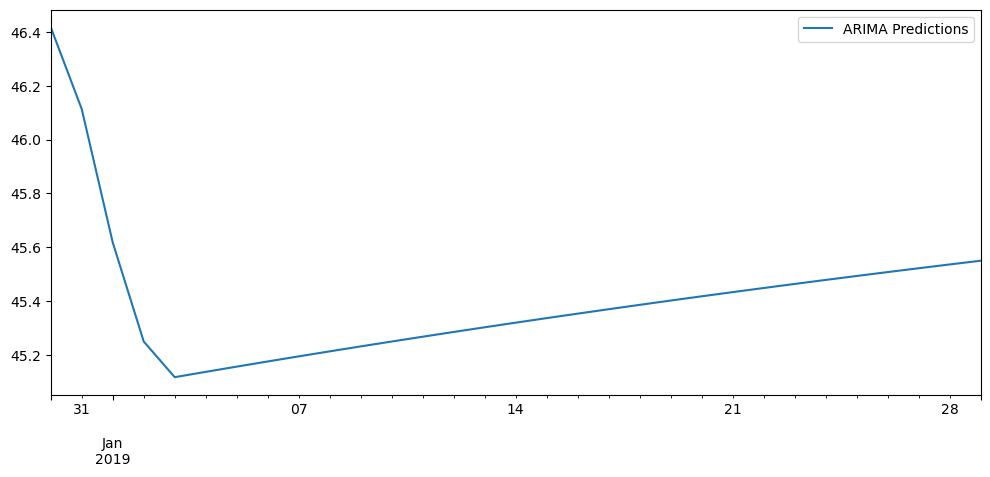

In [63]:
pred.plot(figsize=(12, 5), legend=True)